## Simulated Data

### Plot data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

t_spacing = 0.01

t = np.arange(0,1+t_spacing,t_spacing)
def true(x):
    return np.sin(2*np.pi*x)
f_t = true(t)
t_samp = np.arange(0,1+t_spacing,0.1)
f_samp = true(t_samp)

plt.plot(t,f_t)
plt.scatter(t_samp,f_samp)

### Interpolate

In [ ]:
from scipy.interpolate import CubicSpline, splrep, splev

cspline = CubicSpline(t_samp, f_samp, bc_type='natural')
f_cspline = cspline(t)

bspline = splrep(t_samp, f_samp, k=3, task = 0, s = 0)
f_bspline = splev(t, bspline)


### Set up error functions

In [ ]:
def sq_error(x, func1, func2 = true, bspline = False):
    if bspline:
        return (splev(x, func1) - func2(x)) ** 2
    else:
        return (func1(x) - func2(x)) ** 2


In [ ]:
from scipy.integrate import quad

cspline_error = quad(lambda x: sq_error(x, func1 = cspline, func2=true), 0, 1)
bspline_error = quad(lambda x: sq_error(x, func1 = bspline, func2=true, bspline=True), 0, 1)


plt.plot(t, f_t, label="true")
plt.plot(t,f_cspline, label=f"cSpline: {cspline_error[0]: .2e}")
plt.plot(t,f_bspline, label=f"bSpline: {bspline_error[0]: .2e}")
plt.legend()

So, approximation from cubic b spline is diff than interpolating cubic spline (which minimizes l2 norm of 2nd derivative)

### 3D

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')


t_spacing = 0.01
t = np.arange(0,1+t_spacing,t_spacing)

def true(t):
    return np.array([np.cos(2*np.pi*t), np.sin(2*np.pi*t), t]).T

f_t = true(t)
t_samp = np.arange(0,1+t_spacing,0.1)
f_samp = true(t_samp)

ax.plot3D(f_t[:,0],f_t[:,1],f_t[:,2])
ax.scatter3D(f_samp[:,0],f_samp[:,1],f_samp[:,2])


### Interpolate

In [ ]:
from scipy.interpolate import CubicSpline, splprep, splev

tck, u_samp = splprep(x=[f_samp[:,0],f_samp[:,1],f_samp[:,2]], k=3, task = 0, s = 0, u=t_samp)
print(f"B-spline has {len(tck[0])} knots")
u_spacing = (u_samp[-1]-u_samp[0])/100
u_spline = np.arange(u_samp[0], u_samp[-1]+u_spacing, u_spacing)

def bsplines(t):
    return np.array(splev(t, tck)).T
f_bspline = bsplines(u_spline)

cspline_fit = [CubicSpline(u_samp, f_samp_i, bc_type='natural') for f_samp_i in f_samp.T]
def csplines(t):
    return np.array([cspline(t) for cspline in cspline_fit]).T

f_cspline = csplines(u_spline)


### Setup error function

In [ ]:
def sq_error(x, func1, func2 = true):
    return np.linalg.norm(func1(x) - func2(x)) ** 2

In [ ]:
from scipy.integrate import quad

cspline_error = quad(lambda x: sq_error(x, func1 = csplines, func2=true), 0, 1)
bspline_error = quad(lambda x: sq_error(x, func1 = bsplines, func2=true), 0, 1)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(f_t[:,0],f_t[:,1],f_t[:,2], label="true")
ax.plot3D(f_bspline[:,0],f_bspline[:,1],f_bspline[:,2], label=f"bSpline: {bspline_error[0]: .2e}")
ax.plot3D(f_cspline[:,0],f_cspline[:,1],f_cspline[:,2], label=f"cSpline: {cspline_error[0]: .2e}")
plt.legend()

## Real Data

In [ ]:
from pathlib import Path
from skimage import io
import numpy as np
import napari
from os.path import exists
from brainlit.utils.session import NeuroglancerSession
from cloudvolume.exceptions import SkeletonDecodeError
from napari_animation import AnimationWidget
from cloudvolume import CloudVolume

dir = "precomputed://s3://open-neurodata/brainlit/brain1"
dir_segments = "precomputed://s3://open-neurodata/brainlit/brain1_segments"
ngl_sess = NeuroglancerSession(mip=0, url=dir, url_segments=dir_segments)

mans = [2,3,4,7,9,10,12,17,22,31,33,34]
idx = 5
errors = np.zeros((2, len(mans)))

num_goal = mans[idx] #2,3,4,7,9,10,12,17,22,31,33,34
num = -1
skel_id = 0

while num < num_goal:
    try:
        ngl_sess.pull_vertex_list(skel_id, [0], 1)
        print(f"Skeleton # {skel_id} exists")
        num += 1
    except SkeletonDecodeError:
        print(f"#{skel_id} invalid")
    skel_id += 1

img, bbox, vox = ngl_sess.pull_vertex_list(
    skel_id - 1, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [50, 50, 15]
)
print(
    f"Image shape: {np.multiply(img.shape, [0.3, 0.3, 1])} microns, {np.product(np.multiply(img.shape, [0.3, 0.3, 1])):e} microns cubed"
)
coords_list = vox
soma_coords = [coords_list[0]]
axon_coords = [coords_list[-1]]
coords_list_og = coords_list


manual_path = (
    "/Users/thomasathey/Documents/mimlab/mouselight/input/images/firstn_quantitative/manual/"
    + str(num)
    + ".swc"
)

coords_list = []
with open(manual_path, "r") as file:
    lines = file.readlines()
    for line in lines:
        if line[0] != "#":
            parts = line.split()
            coord = [float(parts[p]) for p in range(2, 5)]
            coord = [int(c) for c in coord]
            coord.reverse()
            coords_list.append(coord)
coords_list.reverse()
coords_list = np.array(coords_list)
soma_coords = [coords_list[0]]
axon_coords = [coords_list[-1]]
coords_list_manual = np.concatenate((coords_list_og[0:1,:],coords_list,coords_list_og[-1:,:]), axis=0)


In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img, scale=[0.3, 0.3, 1])
viewer.add_shapes(
    coords_list_manual,
    shape_type="path",
    edge_width=2,
    edge_color="green",
    name="truth",
    scale=[0.3, 0.3, 1],
)
viewer.add_shapes(
    coords_list_og,
    shape_type="path",
    edge_width=2,
    edge_color="red",
    name="og",
    scale=[0.3, 0.3, 1],
)

viewer.add_points(soma_coords, face_color="orange", size=8, scale=[0.3, 0.3, 1])
viewer.add_points(axon_coords, face_color="red", size=8, scale=[0.3, 0.3, 1])
viewer.camera.angles = [0, -90, -90]
napari.run()

In [ ]:
import similaritymeasures

og_ra = np.multiply(np.array(coords_list_og), [0.3, 0.3, 1])
man_ra = np.multiply(np.array(coords_list_manual), [0.3, 0.3, 1])

tck, u = splprep(list(og_ra.T), k=1, task=0, s=0)
u_step = (u[-1]-u[0])/100
us = np.arange(u[0], u[-1]+u_step, u_step)
spline1 = np.array(splev(us, tck)).T
f1 = similaritymeasures.frechet_dist(man_ra, spline1)

tck3, u = splprep(list(og_ra.T), k=3, task=0, s=0)
u_step = (u[-1]-u[0])/100
us3 = np.arange(u[0], u[-1]+u_step, u_step)
spline3 = np.array(splev(us3, tck3)).T
f3 = similaritymeasures.frechet_dist(man_ra, spline3)


similaritymeasures.frechet_dist(spline1, spline3)

errors[0, idx] = f1
errors[1, idx] = f3

In [ ]:
ax = plt.axes(projection='3d')

ax.scatter3D(og_ra[:,0],og_ra[:,1],og_ra[:,2], label="og")
ax.scatter3D(man_ra[:,0],man_ra[:,1],man_ra[:,2], label="manual")
ax.plot3D(spline1[:,0],spline1[:,1],spline1[:,2], label=f"1d: {f1:.2e}")
ax.plot3D(spline3[:,0],spline3[:,1],spline3[:,2], label=f"3d {f3:.2e}")
ax.legend()

## Loop

In [195]:
from pathlib import Path
from skimage import io
import numpy as np
import napari
from os.path import exists
from brainlit.utils.session import NeuroglancerSession
from cloudvolume.exceptions import SkeletonDecodeError
from napari_animation import AnimationWidget
from cloudvolume import CloudVolume

dir = "precomputed://s3://open-neurodata/brainlit/brain1"
dir_segments = "precomputed://s3://open-neurodata/brainlit/brain1_segments"
ngl_sess = NeuroglancerSession(mip=0, url=dir, url_segments=dir_segments)

mans = [2,3,4,7,9,10,12,17,22,31,33,34]
errors = np.zeros((2, len(mans)))

for idx in range(0, len(mans)):
    print(f"******************{idx}***************")

    num_goal = mans[idx] #2,3,4,7,9,10,12,17,22,31,33,34
    num = -1
    skel_id = 0

    while num < num_goal:
        try:
            ngl_sess.pull_vertex_list(skel_id, [0], 1)
            num += 1
        except SkeletonDecodeError:
            print(f"#{skel_id} invalid")
        skel_id += 1

    img, bbox, vox = ngl_sess.pull_vertex_list(
        skel_id - 1, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [50, 50, 15]
    )
    coords_list = vox
    soma_coords = [coords_list[0]]
    axon_coords = [coords_list[-1]]
    coords_list_og = coords_list


    manual_path = (
        "/Users/thomasathey/Documents/mimlab/mouselight/input/images/firstn_quantitative/manual/"
        + str(num)
        + ".swc"
    )

    coords_list = []
    with open(manual_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            if line[0] != "#":
                parts = line.split()
                coord = [float(parts[p]) for p in range(2, 5)]
                coord = [int(c) for c in coord]
                coord.reverse()
                coords_list.append(coord)
    coords_list.reverse()
    coords_list = np.array(coords_list)
    soma_coords = [coords_list[0]]
    axon_coords = [coords_list[-1]]
    coords_list_manual = np.concatenate((coords_list_og[0:1,:],coords_list,coords_list_og[-1:,:]), axis=0)


    og_ra = np.multiply(np.array(coords_list_og), [0.3, 0.3, 1])
    man_ra = np.multiply(np.array(coords_list_manual), [0.3, 0.3, 1])

    tck, u = splprep(list(og_ra.T), k=1, task=0, s=0)
    u_step = (u[-1]-u[0])/100
    us = np.arange(u[0], u[-1]+u_step, u_step)
    spline1 = np.array(splev(us, tck)).T
    f1 = similaritymeasures.frechet_dist(man_ra, spline1)

    tck3, u = splprep(list(og_ra.T), k=3, task=0, s=0)
    u_step = (u[-1]-u[0])/100
    us3 = np.arange(u[0], u[-1]+u_step, u_step)
    spline3 = np.array(splev(us3, tck3)).T
    f3 = similaritymeasures.frechet_dist(man_ra, spline3)


    similaritymeasures.frechet_dist(spline1, spline3)

    errors[0, idx] = f1
    errors[1, idx] = f3

******************0***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 72/72 [00:05<00:00, 13.90it/s]


******************1***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 40/40 [00:02<00:00, 13.89it/s]


******************2***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 42/42 [00:02<00:00, 14.29it/s]


******************3***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]


#15 invalid
#16 invalid
#17 invalid
#18 invalid
#19 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


#21 invalid
#22 invalid
#23 invalid


Downloading: 100%|██████████| 392/392 [00:26<00:00, 14.66it/s]


******************4***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


#15 invalid
#16 invalid
#17 invalid
#18 invalid
#19 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


#21 invalid
#22 invalid
#23 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


#25 invalid
#26 invalid
#27 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


#29 invalid
#30 invalid
#31 invalid
#32 invalid
#33 invalid
#34 invalid


Downloading: 100%|██████████| 20/20 [00:01<00:00, 12.50it/s]


******************5***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


#15 invalid
#16 invalid
#17 invalid
#18 invalid
#19 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


#21 invalid
#22 invalid
#23 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


#25 invalid
#26 invalid
#27 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


#29 invalid
#30 invalid
#31 invalid
#32 invalid
#33 invalid
#34 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


#36 invalid
#37 invalid
#38 invalid
#39 invalid


Downloading: 100%|██████████| 16/16 [00:01<00:00, 13.19it/s]


******************6***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


#15 invalid
#16 invalid
#17 invalid
#18 invalid
#19 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


#21 invalid
#22 invalid
#23 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


#25 invalid
#26 invalid
#27 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


#29 invalid
#30 invalid
#31 invalid
#32 invalid
#33 invalid
#34 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


#36 invalid
#37 invalid
#38 invalid
#39 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


#41 invalid
#42 invalid
#43 invalid
#44 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


#46 invalid
#47 invalid


Downloading: 100%|██████████| 27/27 [00:02<00:00, 13.18it/s]


******************7***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


#15 invalid
#16 invalid
#17 invalid
#18 invalid
#19 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


#21 invalid
#22 invalid
#23 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


#25 invalid
#26 invalid
#27 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


#29 invalid
#30 invalid
#31 invalid
#32 invalid
#33 invalid
#34 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


#36 invalid
#37 invalid
#38 invalid
#39 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


#41 invalid
#42 invalid
#43 invalid
#44 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


#46 invalid
#47 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


#50 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


#52 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


#54 invalid
#55 invalid
#56 invalid
#57 invalid
#58 invalid


Downloading: 100%|██████████| 54/54 [00:03<00:00, 14.29it/s]


******************8***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


#15 invalid
#16 invalid
#17 invalid
#18 invalid
#19 invalid


Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


#21 invalid
#22 invalid
#23 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


#25 invalid
#26 invalid
#27 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


#29 invalid
#30 invalid
#31 invalid
#32 invalid
#33 invalid
#34 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


#36 invalid
#37 invalid
#38 invalid
#39 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


#41 invalid
#42 invalid
#43 invalid
#44 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


#46 invalid
#47 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


#50 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


#52 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


#54 invalid
#55 invalid
#56 invalid
#57 invalid
#58 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


#61 invalid
#62 invalid
#63 invalid
#64 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


#66 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


#68 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


#70 invalid


Downloading: 100%|██████████| 27/27 [00:02<00:00, 13.28it/s]


******************9***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


#15 invalid
#16 invalid
#17 invalid
#18 invalid
#19 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


#21 invalid
#22 invalid
#23 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


#25 invalid
#26 invalid
#27 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


#29 invalid
#30 invalid
#31 invalid
#32 invalid
#33 invalid
#34 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


#36 invalid
#37 invalid
#38 invalid
#39 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


#41 invalid
#42 invalid
#43 invalid
#44 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


#46 invalid
#47 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


#50 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


#52 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


#54 invalid
#55 invalid
#56 invalid
#57 invalid
#58 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


#61 invalid
#62 invalid
#63 invalid
#64 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


#66 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


#68 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


#70 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


#80 invalid


Downloading: 100%|██████████| 72/72 [00:05<00:00, 14.35it/s]


******************10***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


#15 invalid
#16 invalid
#17 invalid
#18 invalid
#19 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


#21 invalid
#22 invalid
#23 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


#25 invalid
#26 invalid
#27 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


#29 invalid
#30 invalid
#31 invalid
#32 invalid
#33 invalid
#34 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


#36 invalid
#37 invalid
#38 invalid
#39 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


#41 invalid
#42 invalid
#43 invalid
#44 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


#46 invalid
#47 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


#50 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


#52 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


#54 invalid
#55 invalid
#56 invalid
#57 invalid
#58 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


#61 invalid
#62 invalid
#63 invalid
#64 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


#66 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


#68 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


#70 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


#80 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


#84 invalid


Downloading: 100%|██████████| 96/96 [00:06<00:00, 14.45it/s]


******************11***************
#0 invalid
#1 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


#3 invalid
#4 invalid
#5 invalid
#6 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


#8 invalid
#9 invalid
#10 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


#15 invalid
#16 invalid
#17 invalid
#18 invalid
#19 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


#21 invalid
#22 invalid
#23 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


#25 invalid
#26 invalid
#27 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


#29 invalid
#30 invalid
#31 invalid
#32 invalid
#33 invalid
#34 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


#36 invalid
#37 invalid
#38 invalid
#39 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


#41 invalid
#42 invalid
#43 invalid
#44 invalid


Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


#46 invalid
#47 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


#50 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


#52 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


#54 invalid
#55 invalid
#56 invalid
#57 invalid
#58 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


#61 invalid
#62 invalid
#63 invalid
#64 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


#66 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


#68 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


#70 invalid


Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


#80 invalid


Downloading: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


#84 invalid


Downloading: 100%|██████████| 160/160 [00:10<00:00, 14.81it/s]


WilcoxonResult(statistic=23.0, pvalue=0.2333984375)

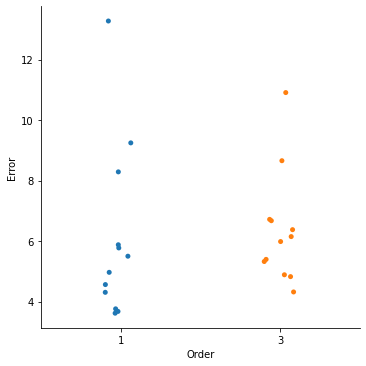

In [197]:
import pandas as pd
import seaborn as sns
from scipy.stats import wilcoxon

dict = {"Order": ["1" for i in range(len(mans))]+["3" for i in range(len(mans))], "Error": list(errors[0,:])+list(errors[1,:])}
df = pd.DataFrame(dict)

sns.catplot(x="Order", y="Error", data=df)
wilcoxon(x=errors[0,:], y=errors[1,:])

In [194]:
errors

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 3.67453124],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 4.31820828]])